# 01 Basics of Kats

https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_101_basics.ipynb

## Setup libraries

In [3]:
import pathlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from kats.consts import TimeSeriesData

## Get data

* wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv
* wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/multi_ts.csv

In [4]:
DATA_DIR = pathlib.Path('.')

TimeSeriesDelta objects can be created from a dataframe which has a "time" column and one or more "value" columns

### Time series with one value

In [25]:
air_passengers_df = pd.read_csv(
    DATA_DIR / 'air_passengers.csv', header=0, names=['time', 'value'])

In [27]:
air_passengers_ts = TimeSeriesData(air_passengers_df)

In [36]:
air_passengers_ts.to_dataframe().head()

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Time series with multiple values

In [37]:
multi_ts_df = pd.read_csv(
    DATA_DIR / 'multi_ts.csv', header=0,
    names=['time', 'v1', 'v2'])

In [38]:
multi_ts = TimeSeriesData(multi_ts_df)

In [39]:
multi_ts.to_dataframe().head()

,time,v1,v2
0,2017-03-12,-0.109,53.8
1,2017-03-13,0.000,53.6
2,2017-03-14,0.178,53.5
3,2017-03-15,0.339,53.5
4,2017-03-16,0.373,53.4


### TimeSeriesData operations

Slicing

In [41]:
air_passengers_ts[1:5]

,time,value
0,1949-02-01,118
1,1949-03-01,132
2,1949-04-01,129
3,1949-05-01,121


Math operations

In [43]:
air_passengers_ts[1:5] + air_passengers_ts[1:5]

,time,value
0,1949-02-01,236
1,1949-03-01,264
2,1949-04-01,258
3,1949-05-01,242


In [44]:
len(air_passengers_ts)

144

Extend

In [51]:
ts_1 = air_passengers_ts[0:2]
ts_1.extend(air_passengers_ts[2:5])

In [52]:
ts_1

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Plotting

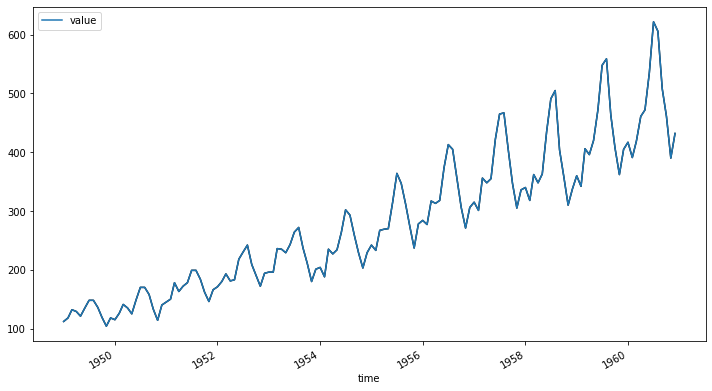

In [53]:
air_passengers_ts.plot(cols=['value'])

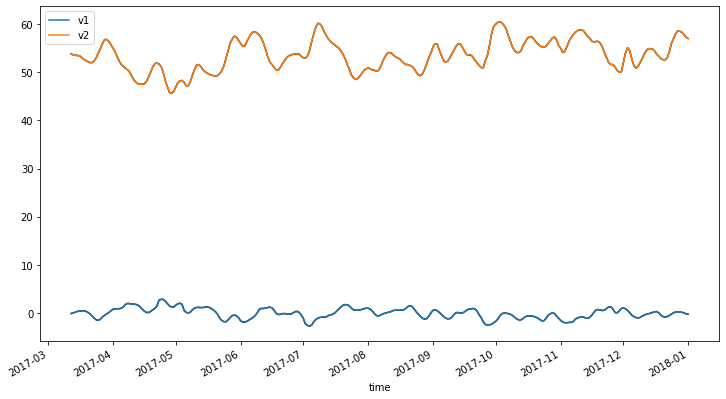

In [54]:
multi_ts.plot(cols=['v1', 'v2'])

### Utility functions

In [55]:
air_passengers_ts.to_dataframe().head()

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [56]:
air_passengers_ts.to_array()[0:3]

array([[Timestamp('1949-01-01 00:00:00'), 112],
       [Timestamp('1949-02-01 00:00:00'), 118],
       [Timestamp('1949-03-01 00:00:00'), 132]], dtype=object)

In [58]:
air_passengers_ts.is_empty()

False

In [59]:
air_passengers_ts.is_univariate()

True

In [60]:
multi_ts.is_univariate()

False

## Forecasting

In [77]:
from kats.models.prophet import ProphetModel, ProphetParams

### Example wth Prophet model

In [78]:
params = ProphetParams(seasonality_mode='multiplicative')

In [79]:
m = ProphetModel(air_passengers_ts, params)

In [80]:
m.fit()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.449     0.0176543       240.422       0.649           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       503.353    0.00108498       90.0341      0.3062      0.3062      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       503.446   0.000140197        80.679           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       503.467   9.96247e-05       114.472   7.079e-07       0.001      451  LS failed, Hessian reset 
     359       503.486   8.82342e-09       72.6598    0.004982           1      538   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Predict for the next 30 months

In [81]:
fcst = m.predict(steps=30, freq="MS")

In [82]:
fcst.head()

,time,fcst,fcst_lower,fcst_upper
0,1961-01-01,452.077721,437.980828,465.284626
1,1961-02-01,433.529496,420.609849,446.021569
2,1961-03-01,492.499917,479.291733,505.668907
3,1961-04-01,495.895518,482.923547,509.474623
4,1961-05-01,504.532773,491.901786,517.277023


Plot with uncertainty intervals

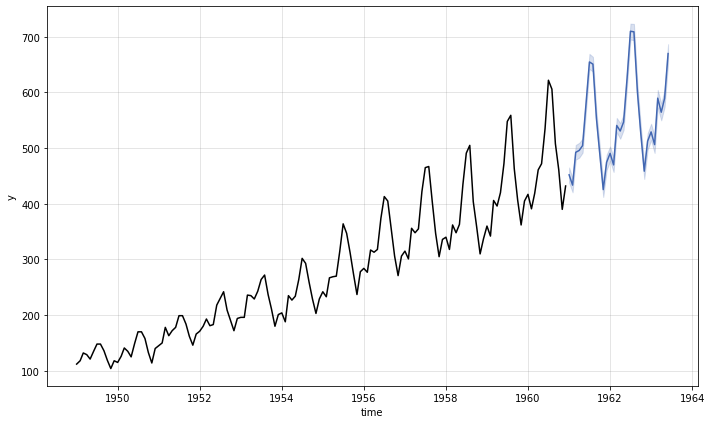

In [84]:
m.plot()

## Detection

### Outlier detection

In [86]:
air_passengers_outlier_df = air_passengers_df.copy(deep=True)

In [88]:
air_passengers_outlier_df.loc[
    air_passengers_outlier_df.time == '1950-12-01', 'value'] *= 5

In [89]:
air_passengers_outlier_df.loc[
    air_passengers_outlier_df.time == '1959-12-01', 'value'] *= 4

<AxesSubplot:>

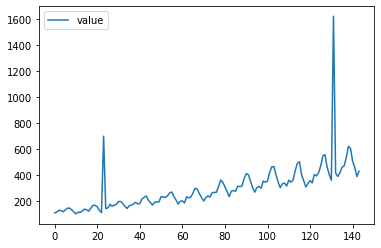

In [91]:
air_passengers_outlier_df.plot()

In [92]:
air_passengers_outlier_ts = TimeSeriesData(air_passengers_outlier_df)

In [93]:
from kats.detectors.outlier import OutlierDetector

In [94]:
ts_outlierDetection = OutlierDetector(
    air_passengers_outlier_ts, 'additive')
ts_outlierDetection.detector()

In [97]:
ts_outlierDetection.outliers[0]

[Timestamp('1950-12-01 00:00:00'),
 Timestamp('1959-11-01 00:00:00'),
 Timestamp('1959-12-01 00:00:00')]

### Changepoint detection

Using the CUSUM algorithm with log likelihood ratio test to detect a change in the mean of the time series

In [99]:
from kats.detectors.cusum_detection import CUSUMDetector

In [100]:
df = pd.DataFrame({
    'time': pd.date_range('2019-01-01', '2019-03-01'),
    'increase': np.concatenate([
        np.random.normal(1, 0.2, 30), np.random.normal(2, 0.2, 30)]),
    'decrease': np.concatenate([
        np.random.normal(1, 0.3, 50), np.random.normal(0.5, 0.3, 10)])
})  

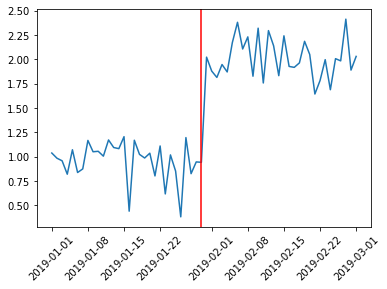

In [103]:
timeseries = TimeSeriesData(df.loc[:, ['time', 'increase']])
detector = CUSUMDetector(timeseries)
change_points = detector.detector(change_directions=["increase"])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

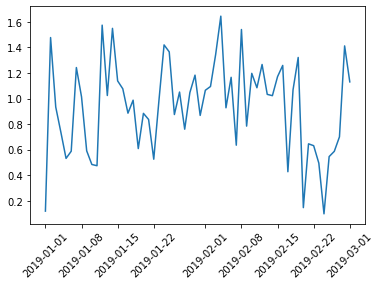

In [105]:
timeseries = TimeSeriesData(df.loc[:, ['time', 'decrease']])
detector = CUSUMDetector(timeseries)
change_points = detector.detector(change_directions=["decrease"])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()